In [29]:
import time
import tensorflow as tf
import wandb
import pandas as pd
from prosit_t.wandb_agent.train_utils import get_proteometools_data
import seaborn as sns
from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance

In [3]:
data_config = {
    "data_source": "/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/data/first_pool_copy.json",
    "fragmentation": "HCD",
    "batch_size": 1024,
    "seq_length": 30,
}

In [4]:
project_name = "transforming-prosit-big-data"
run = wandb.init(project=project_name)

wandb: Currently logged in as: mamisashvili-lizi (prosit-compms). Use `wandb login --relogin` to force relogin


In [39]:
artifact_paths = [
#     "prosit-compms/transforming-prosit-big-data/model-worthy-bee-27:v19",
    "prosit-compms/transforming-prosit-big-data/model-dark-terrain-23:v19",
    "prosit-compms/transforming-prosit-big-data/model-bright-gorge-11:v5",
    "mamisashvili-lizi/transforming-prosit/model-youthful-glitter-3974:v19",
    "mamisashvili-lizi/transforming-prosit/model-dazzling-jazz-3969:v19"
]

In [31]:
def record_time(artifact_paths, batch):
    time_dict = {}
    for path in artifact_paths:
        artifact = run.use_artifact(path)
        model_dir = artifact.download()
        model = tf.keras.models.load_model(model_dir, custom_objects={
            "masked_spectral_distance": masked_spectral_distance,
            "masked_pearson_correlation_distance": masked_pearson_correlation_distance
        })
        start_time = time.time()
        model(batch)
        end_time = time.time()
        time_dff = end_time - start_time
        model_name = path.split("/")[-1]
        time_dict[model_name] = [time_dff]
    return pd.DataFrame.from_dict(time_dict)

In [32]:
_, val_data = get_proteometools_data(data_config)

In [35]:
batch = [i[0] for i in val_data.take(1)][0]

In [42]:
df = record_time(artifact_paths, batch)

wandb:   4 of 4 files downloaded.  
2023-07-24 16:06:30.093697: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A40" frequency: 1740 num_cores: 84 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 24564662272 bandwidth: 696096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
wandb:   4 of 4 files downloaded.  
2023-07-24 16:06:34.773840: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device 

[Text(0, 0, 'model-dark-terrain-23:v19'),
 Text(1, 0, 'model-bright-gorge-11:v5'),
 Text(2, 0, 'model-youthful-glitter-3974:v19'),
 Text(3, 0, 'model-dazzling-jazz-3969:v19')]

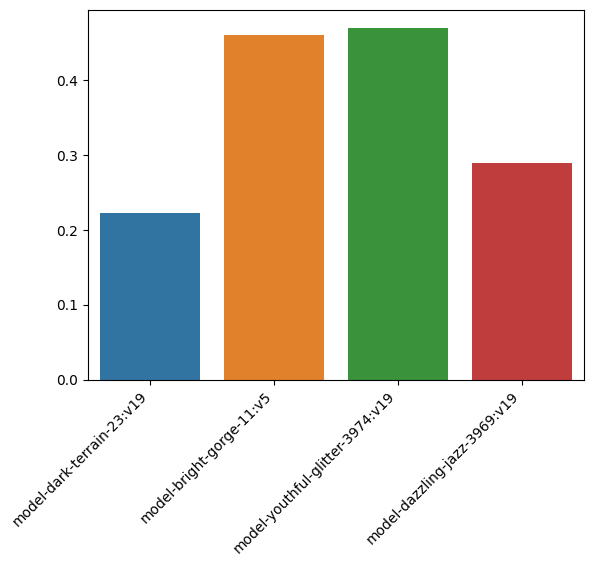

In [51]:
plt = sns.barplot(df)
plt.set_xticklabels(plt.get_xticklabels(), rotation=45, ha='right')
